<a href="https://colab.research.google.com/github/ambideXtrous9/PyTorch-Models/blob/main/Xception_Flickr27_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install --quiet imutils
!pip install --quiet wget
!pip install --quiet split-folders
!pip install --quiet timm
!pip install --quiet pytorch-lightning
!pip install --quiet torchmetrics
!pip install --quiet rich

In [2]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import torchmetrics
import timm
import wget
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import cv2
import tensorflow as tf
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [4]:
!ls

flickr_logos_27_dataset.tar.gz	sample_data


In [5]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101827904/101827904 [==============================] - 40s 0us/step


In [6]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [11]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [12]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [13]:
dtdir = './flickr_logos_27_dataset_images/'

In [14]:
im = df[0][0]

In [15]:
size = df.iloc[:,3:]

In [16]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [17]:
img = os.path.join(dtdir,im)

In [18]:
size = size.values.tolist()

In [19]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

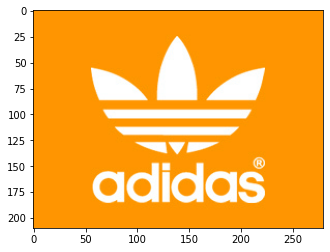

In [20]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

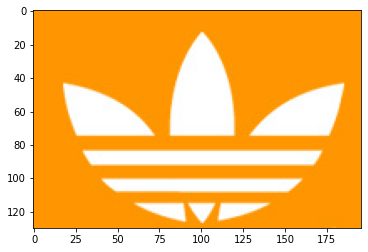

In [21]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [22]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [23]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

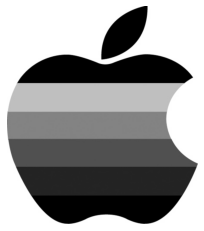

In [24]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
plt.axis("off")
image.shape

In [25]:
y = list(set(list(Y)))
y.sort()

In [26]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [27]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [28]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [29]:
HEIGHT = 224
WIDTH =  224

## Removing Corrupt Images 

In [30]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [31]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [32]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [33]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [34]:
imagePaths = list(paths.list_images(dest))

LOGOS/Vodafone/2908611911.jpg


(224, 224, 3)

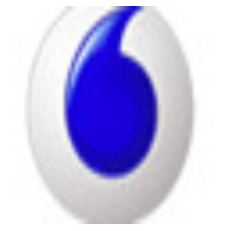

In [35]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
plt.axis("off")
image.shape

## Train Val Split

In [36]:
path = 'LOGOS'

In [37]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

Copying files: 944 files [00:00, 7218.09 files/s]


## Image Augmentation

In [38]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

In [39]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,transforms.ToTensor(),nrml])

In [40]:
BS = 256
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 755 samples...
[INFO] validation dataset contains 189 samples...


In [41]:
class LitNeuralNet(pl.LightningModule):
    def __init__(self,num_classes):
        super(LitNeuralNet, self).__init__()
        
        
        self.model = timm.create_model('xception', pretrained=True)
        self.model.aux_logits=False

        # Freeze training for all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Sequential(
                      nn.Linear(self.model.fc.in_features, 512), 
                      nn.BatchNorm1d(512),
                      nn.Dropout(0.4),
                      nn.ReLU(inplace=True),
                      nn.Linear(512, 256), 
                      nn.BatchNorm1d(256),
                      nn.Dropout(0.4),
                      nn.ReLU(inplace=True),
                      nn.Linear(256, num_classes),
                      nn.Softmax())
        # add metrics
        self.acc = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes)
        
    def forward(self, x):
        out = self.model(x)
        return out

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=2,batch_size=BS, shuffle=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=2,batch_size=BS,shuffle=False)
        
        return valDataLoader

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.CrossEntropyLoss()
        loss = lossfn(outputs, labels)
        
        #y_pred = torch.exp(outputs)
        y_pred = torch.argmax(outputs,dim=1)
        #y_pred = output.data.max(1, keepdim=True)[1]
        train_acc = self.acc(y_pred, labels)
        # just accumulate

        self.log("train_loss", loss)
        self.log("train_accuracy", train_acc)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}
    
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.forward(images)
        lossfn = nn.CrossEntropyLoss()   
        loss = lossfn(outputs, labels)
        
        #pred = torch.exp(outputs)
        y_pred = torch.argmax(outputs,dim=1)
        #pred = output.data.max(1, keepdim=True)[1]
        self.acc.update(y_pred, labels)

        self.log("val_loss", loss)
        return {"val_loss": loss}
            
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_accuracy = self.acc.compute()
        # log metrics
        self.log("val_accuracy", val_accuracy)
        self.log("val_loss", avg_loss)
        # reset all metrics
        self.acc.reset()
        print(f"\nVal Accuracy: {val_accuracy:.4} "\
        f"Val Loss: {avg_loss:.4}")
        
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters())


In [42]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-5,
    divergence_threshold=9.0,
    check_finite=True)

INFO:lightning_lite.utilities.seed:Global seed set to 123


In [43]:
#from pytorch_lightning.loggers import WandbLogger

In [44]:
#wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

In [45]:
model = LitNeuralNet(num_classes=len(trainDataset.classes))
trainer = Trainer(accelerator='gpu', devices=-1,max_epochs=100,log_every_n_steps=8)#,callbacks=[early_stopping])
trainer.fit(model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type               | Params
---------------------------------------------
0 | model | Xception           | 22.0 M
1 | acc   | MulticlassAccuracy | 0     
---------------------------------------------
1.2 M     Trainable params
20.8 M    Non-trainable params
22.0 M    Total params
87.983    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Val Accuracy: 0.06878 Val Loss: 3.296


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=8). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.09958 Val Loss: 3.294


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.2807 Val Loss: 3.29


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.3665 Val Loss: 3.28


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4121 Val Loss: 3.262


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4333 Val Loss: 3.23


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4619 Val Loss: 3.185


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4661 Val Loss: 3.136


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4831 Val Loss: 3.086


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.4873 Val Loss: 3.037


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5064 Val Loss: 2.999


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5159 Val Loss: 2.977


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5297 Val Loss: 2.964


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5275 Val Loss: 2.955


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5434 Val Loss: 2.948


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5371 Val Loss: 2.941


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5519 Val Loss: 2.935


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5572 Val Loss: 2.926


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5593 Val Loss: 2.923


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5689 Val Loss: 2.916


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5911 Val Loss: 2.903


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.5837 Val Loss: 2.894


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6049 Val Loss: 2.888


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6081 Val Loss: 2.88


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6197 Val Loss: 2.876


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6377 Val Loss: 2.879


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6208 Val Loss: 2.878


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6483 Val Loss: 2.875


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6494 Val Loss: 2.878


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6515 Val Loss: 2.878


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6695 Val Loss: 2.867


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6748 Val Loss: 2.856


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6886 Val Loss: 2.846


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.6992 Val Loss: 2.838


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7214 Val Loss: 2.834


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7203 Val Loss: 2.83


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7479 Val Loss: 2.824


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7511 Val Loss: 2.8


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7564 Val Loss: 2.795


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7638 Val Loss: 2.792


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7701 Val Loss: 2.785


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.7754 Val Loss: 2.774


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8051 Val Loss: 2.761


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8114 Val Loss: 2.758


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8072 Val Loss: 2.768


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.821 Val Loss: 2.762


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.822 Val Loss: 2.756


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8337 Val Loss: 2.746


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8337 Val Loss: 2.745


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8422 Val Loss: 2.734


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8358 Val Loss: 2.728


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8443 Val Loss: 2.717


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8517 Val Loss: 2.715


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8591 Val Loss: 2.715


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8581 Val Loss: 2.707


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8708 Val Loss: 2.712


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8633 Val Loss: 2.719


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8581 Val Loss: 2.712


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8718 Val Loss: 2.705


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8867 Val Loss: 2.704


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8729 Val Loss: 2.699


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8803 Val Loss: 2.689


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8761 Val Loss: 2.683


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8729 Val Loss: 2.676


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8782 Val Loss: 2.672


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8729 Val Loss: 2.676


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8739 Val Loss: 2.685


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8761 Val Loss: 2.681


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8771 Val Loss: 2.672


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8771 Val Loss: 2.679


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8824 Val Loss: 2.696


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8782 Val Loss: 2.703


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8803 Val Loss: 2.687


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8877 Val Loss: 2.685


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8761 Val Loss: 2.69


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8792 Val Loss: 2.693


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8856 Val Loss: 2.689


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8941 Val Loss: 2.691


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8909 Val Loss: 2.679


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8909 Val Loss: 2.676


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8962 Val Loss: 2.671


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.9004 Val Loss: 2.673


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8856 Val Loss: 2.679


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8803 Val Loss: 2.686


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8708 Val Loss: 2.689


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8867 Val Loss: 2.691


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8856 Val Loss: 2.701


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8803 Val Loss: 2.705


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8782 Val Loss: 2.706


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8867 Val Loss: 2.699


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8835 Val Loss: 2.69


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8941 Val Loss: 2.684


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8845 Val Loss: 2.685


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8845 Val Loss: 2.679


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8898 Val Loss: 2.676


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8972 Val Loss: 2.682


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8909 Val Loss: 2.681


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8824 Val Loss: 2.682


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8919 Val Loss: 2.686


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8972 Val Loss: 2.688


Validation: 0it [00:00, ?it/s]


Val Accuracy: 0.8888 Val Loss: 2.679


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Prediction On Test Images

In [46]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

![image.png](attachment:dbacbc64-b039-4beb-877c-5061780c5dc3.png)

In [47]:
def predimg(path):
    from PIL import Image
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show() 
    model.eval()
    with torch.no_grad():
      img =  load_img(path)
      mean = [0.485, 0.456, 0.406] 
      std = [0.229, 0.224, 0.225]
      transform_norm = transforms.Compose([transforms.ToTensor(), 
      transforms.Resize((224,224)),transforms.Normalize(mean, std)])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze(0)
      img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
      img = img_normalized#.to(device)
      img = DataLoader(img, num_workers=4,batch_size=BS,shuffle=False)
      output = trainer.predict(model,img)
      output = output[0][0]
      #print(output)
      index = output.data.cpu().numpy().argmax()
      result = list(np.around(output.data.cpu().numpy()*100,1))
      print(result)
      print("PREDICTED CLASS = ",trainDataset.classes[index])

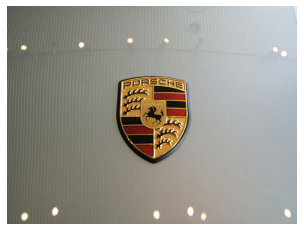

<ipython-input-47-c0ef1150ac03>:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lig

Predicting: 3it [00:00, ?it/s]

[0.0, 0.1, 0.1, 0.0, 0.0, 0.1, 0.0, 0.9, 0.6, 0.0, 0.0, 1.5, 0.0, 0.0, 0.1, 0.0, 0.5, 0.0, 95.3, 0.2, 0.1, 0.0, 0.3, 0.1, 0.0, 0.0, 0.0]
PREDICTED CLASS =  Porsche


In [48]:
predimg(testimage[25])

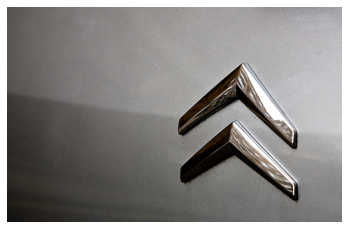

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.3, 0.0, 0.0, 97.9, 0.1, 0.1, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0]
PREDICTED CLASS =  Citroen


In [55]:
predimg(testimage[15])

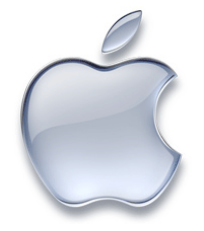

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
PREDICTED CLASS =  Apple


In [50]:
predimg(testimage[16])

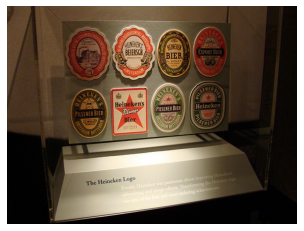

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.9, 0.0, 0.0, 0.0, 0.2, 0.1, 0.0, 0.2, 0.4, 0.0, 0.0, 57.6, 0.0, 0.0, 36.9, 0.0, 0.2, 0.0, 0.2, 0.1, 2.6, 0.0, 0.1, 0.0, 0.0, 0.3, 0.0]
PREDICTED CLASS =  Heineken


In [51]:
predimg(testimage[77])

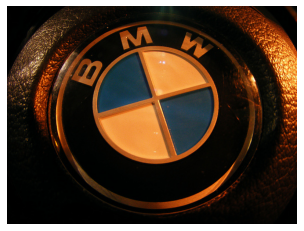

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.3, 0.1, 97.0, 0.3, 0.0, 0.3, 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.3, 0.0, 1.4, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
PREDICTED CLASS =  BMW


In [52]:
predimg(testimage[12])

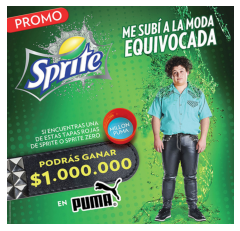

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.4, 0.4, 0.0, 2.2, 0.7, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 68.9, 0.0, 0.0, 24.8, 1.7, 0.1]
PREDICTED CLASS =  Sprite


In [53]:
predimg(testimage[1])

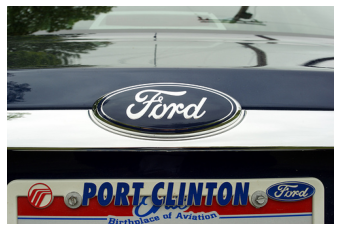

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3it [00:00, ?it/s]

[0.0, 0.0, 0.2, 0.5, 0.0, 0.0, 0.0, 0.1, 90.9, 0.0, 0.2, 3.9, 0.0, 0.0, 2.7, 0.0, 0.1, 0.0, 0.1, 0.6, 0.0, 0.1, 0.2, 0.0, 0.0, 0.0, 0.1]
PREDICTED CLASS =  Ford


In [54]:
predimg(testimage[9])